# The Mouse Cortical Model + Advanced Features

The goal of this chapter is an introduction to how with more realistic models one might use some of the advanced features of the BMTK. 

These features can be useful whether you are building a more realistic network model from scratch or intend to carry out simulations of an existing model like the Allen Institute models of the Mouse Primary Visual Cortex (see [here](https://portal.brain-map.org/explore/models/mv1-all-layers)). 

In modeling practice, it is often the case that one needs to use such an existing model with some modifications. Many possibilities to do so are offered by the modular SONATA format, where one can modify the config files and/or the data files containing components of the model, such as nodes, edges, cell and synapse models, etc. 

In addition, BMTK offers ways to change certain aspects of the models at runtime. This can sometimes be preferable to replacing the static structure of the model, for example, in cases when one may need to sample many different conditions in separate simulations. Rebuilding components of the model for every simulation may be cumbersome in such a situation. Some approaches for runtime modifications are illustrated below. 

Throughout this chapter, we will use a reduced version of the network model of the Layer 4 (L4) from the mouse V1 (full version can be found [here](https://portal.brain-map.org/explore/models/mv1-all-layers)). The complete V1 model (230,000 neurons) or just the model of V1 L4 (45,000 neurons) are too large for quick training simulations. Therefore, we are using here a smaller (2,300 neurons) network model employing only point neurons with less diversity and complexity in the node and edge types; however, all the operations illustrated in this chapter can be successfully applied to much larger and more complex networks.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import h5py
import glob
import nest

from bmtk.analyzer.spike_trains import plot_rates_boxplot, plot_rates, plot_raster
from bmtk.utils import sonata
from bmtk.utils.reports import SpikeTrains


pd.set_option('display.max_rows', None)

## [6A. Building the Model](6A.%20Building%20the%20L4%20Network.ipynb)

We have already built a reduced model of the Mouse Primary Visual Cortex with only Layer 4 cells which has been saved in the **network/** directory. The rules used to build the network are not necessary for the rest of the chapter, and can be time consuming to rebuild from scratch. But should one be interested in how the network was built more details can be found [here](6A.%20Building%20the%20L4%20Network.ipynb).

The core of the network is internal "L4" (Layer 4) cells saved in the l4_nodes.h5 and l4_node_types.csv files. To get a sense of the make-up of the network let's use ```bmtk.utils.sonata``` functionality to load the nodes into a Pandas DataFrame:

In [2]:
net = sonata.File(
    data_files='network/l4_nodes.h5',
    data_type_files='network/l4_node_types.csv'
)
l4_nodes_df = net.nodes['l4'].to_dataframe(index_by_id=False)
l4_nodes_df[['layer', 'ei', 'model_name',  'dynamics_params', 'model_template', 'model_type','node_id']]  \
    .groupby(['layer', 'ei', 'model_name', 'model_template', 'model_type', 'dynamics_params'])   \
    .agg('count')  \
    .rename(columns={'node_id':'node_count'})

node_count
layer ei model_name       model_template        model_type   dynamics_params                               
VisL4 e  Rorb_314642645   nest:glif_lif_asc_psc point_neuron 314642645_glif_lif_asc_config.json         594
         Scnn1a_517982558 nest:glif_lif_asc_psc point_neuron 517982558_glif_lif_asc_config.json         686
         other_483018019  nest:glif_lif_asc_psc point_neuron 483018019_glif_lif_asc_config.json         732
      i  Htr3a_474626527  nest:glif_lif_asc_psc point_neuron 474626527_glif_lif_asc_config.json          61
         Pvalb_478958894  nest:glif_lif_asc_psc point_neuron 478958894_glif_lif_asc_config.json         223
         Sst_501282204    nest:glif_lif_asc_psc point_neuron 501282204_glif_lif_asc_config.json         119

Let us also look at the overall makeup of the recurrent (L4 --> L4) connections:

In [3]:
l4_edges_df = pd.read_csv('network/l4_l4_edge_types.csv', sep=' ').sort_values(['dynamics_params', 'target_query'])
with h5py.File('network/l4_l4_edges.h5', 'r') as h5:
    edge_ids, edge_counts = np.unique(h5['/edges/l4_to_l4/edge_type_id'][()], return_counts=True)
    edge_counts_df = pd.DataFrame({'edge_type_id': edge_ids, 'counts': edge_counts})
    l4_edges_df = l4_edges_df.merge(edge_counts_df, how='left', on='edge_type_id')

l4_edges_df.set_index(['edge_type_id', 'target_query', 'source_query', 'dynamics_params'])

,,,,syn_weight,delay,weight_sigma,weight_function,model_template,counts
edge_type_id,target_query,source_query,dynamics_params,,,,,,
107,cell_line=='e4Rorb',cell_line=='e4Rorb',e2e.json,5.154132,1.3,30.0,DirectionRule_EE,static_synapse,26060
113,cell_line=='e4Rorb',cell_line=='e4Scnn1a',e2e.json,5.154132,1.3,30.0,DirectionRule_EE,static_synapse,29915
125,cell_line=='e4Rorb',cell_line=='e4other',e2e.json,5.154132,1.3,30.0,DirectionRule_EE,static_synapse,32074
108,cell_line=='e4Scnn1a',cell_line=='e4Rorb',e2e.json,13.687266,1.3,30.0,DirectionRule_EE,static_synapse,29609
114,cell_line=='e4Scnn1a',cell_line=='e4Scnn1a',e2e.json,13.687266,1.3,30.0,DirectionRule_EE,static_synapse,34341
126,cell_line=='e4Scnn1a',cell_line=='e4other',e2e.json,13.687266,1.3,30.0,DirectionRule_EE,static_synapse,36462
110,cell_line=='e4other',cell_line=='e4Rorb',e2e.json,5.443508,1.3,30.0,DirectionRule_EE,static_synapse,32077
116,cell_line=='e4other',cell_line=='e4Scnn1a',e2e.json,5.443508,1.3,30.0,DirectionRule_EE,static_synapse,36294
128,cell_line=='e4other',cell_line=='e4other',e2e.json,5.443508,1.3,30.0,DirectionRule_EE,static_synapse,38328


## [6B. Generating Synaptic Inputs](6B.%20Creating%20Synaptic%20Inputs.ipynb)

Next step is generating spike-train inputs to the network model.

One can create any number of external node populations that provide such inputs. Here we will use two such populations. Since our network model is based on the mouse V1, which receives major inputs from the Lateral Geniculate Nucleus (LGN) of the thalamus, one of the external populations, labeled “lgn”, will represent these visual inputs. The other will represent inputs from everything else (the rest of the brain outside of V1 and LGN) to V1 – something one can call the background input, hence the population name “bkg”. These two populations provide feed-forward synaptic inputs into our simplified V1 L4 model (of course, in reality, V1 provides feedback to the thalamus as well as sends signals to other parts of the brain too).

Generating realistic inputs for the full "lgn" model using ```FilterNet``` can be time consuming, so we already pre-generated them in the **inputs/** directory. The files _spikes.\*.h5_ within this directory contain SONATA spike-trains we can use when running simulations of our model:

In [4]:
print('Valid SONATA inputs:')
for spikes_file in glob.glob('inputs/spikes.*.h5'):
    print('->', spikes_file)

Valid SONATA inputs:
-> inputs/spikes.gratings.0deg_2Hz.h5
-> inputs/spikes.gratings.45deg_2Hz.h5
-> inputs/spikes.gratings.0deg_4Hz.h5
-> inputs/spikes.gratings.45deg_4Hz.h5
-> inputs/spikes.gratings.90deg_2Hz.h5
-> inputs/spikes.gratings.90deg_4Hz.h5


However, should you want to generate a different set of input spikes, or regenerate the existing ones (required if the lgn coordinates have been changed, since spiking is dependent on the position of the receptive field in the visual space) please see the notebook [here](6B.%20Creating%20Synaptic%20Inputs.ipynb).

## [6C. Tuning Model Parameters](6C.%20Parameter%20Tuning.ipynb)

Typically before running the full model and getting back usable results there is a lot of parameter tuning. This process can take a significant amount of time and effort as the robustness of any given model can vary widely. And any changes to the number of cells, their models, the number and topology of connections can have a big effect on the results of a medium to large network. In particularly the synaptic weight parameter, or *syn_weight* in the SONATA files, require particular attention.

For the "l4" model built in [6A](6A.%20Building%20the%20L4%20Network.ipynb) and [6B](6B.%20Creating%20Synaptic%20Inputs.ipynb) the *syn_weight*'s and other parameters have already been tuned so we can proceed with the rest of the tutorial. However BMTK does include some advanced features which can help with the parameter search and optimization process which you can read about [here in tutorial 6C](6C.%20Parameter%20Tuning.ipynb).


## 6D. Running the Model


#### LGN feedforward connections only

First we'll start by testing and optimizing the network with LGN feedforward connections only, that is without the recurrent connections. The main focus will be on the synaptic weights or *syn_weight* parameter such that the various cell-type models are spiking with an appropriate baseline firing-rate.

To run the simulation with only feedforward synaptic connections all we need to do is adjust the "network" section of the configuration so that "l4->l4" connections are excluded.

```json
  "networks": {
    "nodes": [
      {
        "nodes_file": "$NETWORK_DIR/l4_nodes.h5",
        "node_types_file": "$NETWORK_DIR/l4_node_types.csv"
      },
      {
        "nodes_file": "$NETWORK_DIR/lgn_nodes.h5",
        "node_types_file": "$NETWORK_DIR/lgn_node_types.csv"
      },
      {
        "nodes_file": "$NETWORK_DIR/bkg_nodes.h5",
        "node_types_file": "$NETWORK_DIR/bkg_node_types.csv"
      }
    ],
    "edges": [
      {
        "edges_file": "$NETWORK_DIR/lgn_l4_edges.h5",
        "edge_types_file": "$NETWORK_DIR/lgn_l4_edge_types.csv"
      },
      {
        "edges_file": "$NETWORK_DIR/bkg_l4_edges.h5",
        "edge_types_file": "$NETWORK_DIR/bkg_l4_edge_types.csv"
      }
    ]
  }

```

In [5]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.simulation_pointnet.feedforward.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

2022-07-24 07:28:51,827 [INFO] Created log file
2022-07-24 07:28:51,862 [INFO] Batch processing nodes for l4/0.
2022-07-24 07:28:52,006 [INFO] Batch processing nodes for lgn/0.
2022-07-24 07:28:52,016 [INFO] Batch processing nodes for bkg/0.
2022-07-24 07:28:52,040 [INFO] Setting up output directory
2022-07-24 07:28:52,041 [INFO] Building cells.
2022-07-24 07:28:52,141 [INFO] Building recurrent connections
2022-07-24 07:28:52,142 [INFO] Build virtual cell stimulations for lgn_spikes
2022-07-24 07:29:28,739 [INFO] Build virtual cell stimulations for bkg_spikes
2022-07-24 07:29:29,042 [INFO] Network created.
2022-07-24 07:29:29,092 [INFO] Starting Simulation
2022-07-24 07:29:36,020 [INFO] Simulation finished, finalizing results.
2022-07-24 07:29:36,328 [INFO] Done.


We can quickly analyze our results by looking at the spike raster and firing rates grouped by their cell type.

Note that in the plot below all i4Sst and i4Htr3a cells produce spike trains that are identical to each other. This is because in this simplified model Sst and Htr3a cells do not receive LGN inputs, and, in the absence of recurrent connections, the only input these cells ‘see’ is that from the background (bkg) which provides identical inputs to all cells of a given type. In this simplified network model, we are using a single cell model for Sst type (and likewise for Htr3a type), and each cell of a given type receives the same number and strengths of synapses from bkg. Thus, at this point all these cells receive identical inputs. In reality, such bkg inputs would be different across cells of the same type. 

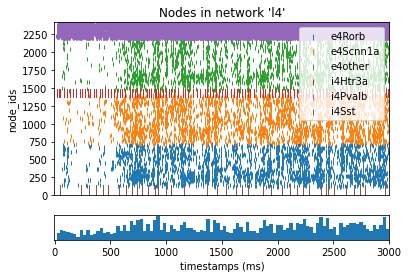

In [6]:
_ = plot_raster(config_file='config.simulation_pointnet.feedforward.json', group_by='cell_line')

/home/kael/apps/miniconda3/envs/bmtk-py38/lib/python3.8/site-packages/matplotlib-3.2.1-py3.8-linux-x86_64.egg/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


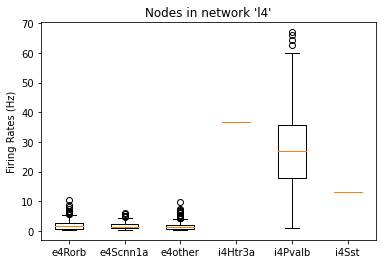

In [7]:
_ = plot_rates_boxplot(config_file='config.simulation_pointnet.feedforward.json', group_by='cell_line')

However, these results don’t tell us how well-tuned the neurons are to the given stimuli. **tuning_angle** is an optional, user-defined property assigned to each node in the SONATA files for this model. Basically, it indicates the direction of motion in the visual space that the cell is intended to prefer. Whether the cell actually prefers that direction or not in any given model and simulation is not guaranteed – that depends on how the model is built and conditions of the simulation. We can use this parameter to inform the lgn connectivity (and also recurrent connectivity) of the units during model construction and then check whether the simulations show the intended orientation selectivity (for more details see [Billeh et al., 2020](https://www.cell.com/neuron/fulltext/S0896-6273(20)30067-2)).

The function below plots the firing rates of excitatory or inhibitory neurons as a function of their **tuning_angle** property.

In [8]:
def plot_tuning_angle_fr(spikes_path, fr_window=(500.0, 3000.0), avg_window=15):
    dur_secs = (fr_window[1] - fr_window[0]) / 1000.0

    net = sonata.File(
        data_files='network/l4_nodes.h5',
        data_type_files='network/l4_node_types.csv'
    )
    nodes_df = net.nodes['l4'].to_dataframe(index_by_id=False)
    nodes_df = nodes_df[['node_id', 'node_type_id', 'model_name', 'tuning_angle', 'model_type', 'layer', 'ei']]
    
    spikes = SpikeTrains.load(spikes_path)
    spikes_df = spikes.to_dataframe(population='l4')

    fr_df = spikes_df['node_ids'][spikes_df.timestamps.between(fr_window[0],fr_window[1])] \
                                  .value_counts()  \
                                  .rename_axis('node_id')  \
                                  .reset_index(name='spike_counts')
    
    fr_df['firing_rates'] = fr_df['spike_counts'].values / dur_secs
    fr_df['node_id'] = fr_df['node_id'].astype(np.uint64)
    fr_df = fr_df.merge(nodes_df, how='right', on='node_id')       
    fr_df['spike_counts'] = fr_df['spike_counts'].fillna(0.0)   
    fr_df['firing_rates'] = fr_df['firing_rates'].fillna(0.0)

    def create_subplot(ax, grp_df, label):
        ax.scatter(grp_df['tuning_angle'], grp_df['firing_rates'], s=2)
        
        fr_avgs = pd.DataFrame({
            'tuning_rounded': np.floor(grp_df['tuning_angle']),
            'firing_rates': grp_df['firing_rates']
        }).groupby('tuning_rounded').agg(np.mean)
        
        if avg_window and len(fr_avgs['firing_rates']) > avg_window:
            tuning_even_spaced = pd.DataFrame({
                'tuning_rounded':np.arange(360)
            })
            fr_avgs=fr_avgs.merge(tuning_even_spaced, how='right', on='tuning_rounded')
            fr_avgs['firing_rates_avg'] = fr_avgs['firing_rates'].rolling(avg_window, min_periods=1).mean()

        ax.plot(fr_avgs['firing_rates_avg'], c='r', linewidth=3, label=label)
        ax.legend(fontsize=10, loc='upper right')
        ax.set_xlabel('Tuning Angle (deg)')
        ax.set_ylabel('Firing Rate (Hz)')

    # plot excitatory cells by layer
    nrows = 2
    fig, axes = plt.subplots(nrows, 1, figsize=(10, 5))
    for r, layer in enumerate(['VisL4']):
        exc_df = fr_df[(fr_df['ei'] == 'e') & (fr_df['layer'] == layer)]
        create_subplot(axes[r], exc_df, 'exc; {}'.format(layer))

    # plot inhibitory cells
    inh_df = fr_df[fr_df['ei'] == 'i']
    create_subplot(axes[r+1], inh_df, 'inh; ALL')

    for r in range(nrows):
        if r != (nrows - 1):
            axes[r].set_xticklabels([])
            
    plt.show()


Now we use the function above to plot the firing rates of neurons as a function of their assigned “tuning_angle” (blue dots), as well as a running average (red line). 

The stimulus we apply here is a grating drifting in the 90 degrees direction. Due to the way we constructed the LGN inputs (following what is known about inputs converging from LGN to V1), the L4 neurons with tuning angle close to 90 degrees show slightly elevated firing rate relative to all other neurons. However, the difference is small.

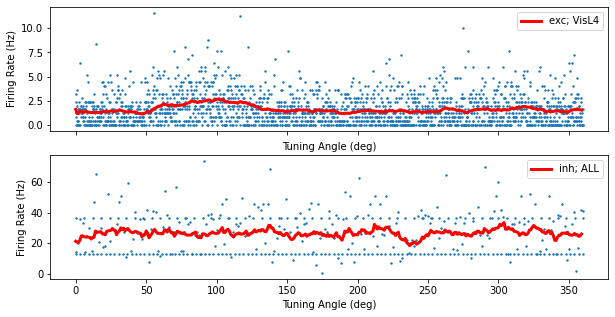

In [9]:
plot_tuning_angle_fr('output_feedforward/spikes.h5')

Let us proceed with the fully recurrent model to see if the situation changes.

#### Full model

We are now ready to run the simulation with the l4-->l4 recurrent connections added back. All we need to do is add the l4-->l4 edges files to our config file:

```json
  "networks": {
    "nodes": [
      {
        "nodes_file": "$NETWORK_DIR/l4_nodes.h5",
        "node_types_file": "$NETWORK_DIR/l4_node_types.csv"
      },
      {
        "nodes_file": "$NETWORK_DIR/lgn_nodes.h5",
        "node_types_file": "$NETWORK_DIR/lgn_node_types.csv"
      },
      {
        "nodes_file": "$NETWORK_DIR/bkg_nodes.h5",
        "node_types_file": "$NETWORK_DIR/bkg_node_types.csv"
      }
    ],
    "edges": [
      {
        "edges_file": "$NETWORK_DIR/l4_l4_edges.h5",
        "edge_types_file": "$NETWORK_DIR/l4_l4_edge_types.csv"
      },
      {
        "edges_file": "$NETWORK_DIR/lgn_l4_edges.h5",
        "edge_types_file": "$NETWORK_DIR/lgn_l4_edge_types.csv"
      },
      {
        "edges_file": "$NETWORK_DIR/bkg_v1_edges.h5",
        "edge_types_file": "$NETWORK_DIR/bkg_v1_edge_types.csv"
      }
    ]
  }
```

However, should we run the simulation as before we would get the following error:
    
<div class="alert alert-block alert-danger">
<b>[ERROR]</b> Unable to calculate synaptic weight for "l4_to_l4" edges, missing "weight_function" attribute value DirectionRule_others function.
</div>

This is because in our L4 --> L4 connections we added a special property "**weight_function**", with rules depending on whether the connections are excitatory-to-excitatory (DirectionRule_EE) or otherwise (DirectionRule_others). The weight_function option is an additional scaling applied to the synaptic weights that provides a dynamic way to adjust the weights in PointNet and BioNet at simulation time without having to rebuild the network. 

In [10]:
edge_types_df = pd.read_csv('network/l4_l4_edge_types.csv', sep=' ')
edge_types_df.iloc[5:10].style.applymap(lambda *_: 'background-color: yellow', subset=pd.IndexSlice[:, 'weight_function'])

,edge_type_id,target_query,source_query,dynamics_params,syn_weight,delay,weight_sigma,weight_function,model_template
5,105,cell_line=='i4Pvalb',cell_line=='i4Sst',i2i.json,-1.120146,1.500000,50.000000,DirectionRule_others,static_synapse
6,106,cell_line=='i4Sst',cell_line=='e4Rorb',e2i.json,3.388120,1.500000,90.000000,DirectionRule_others,static_synapse
7,107,cell_line=='e4Rorb',cell_line=='e4Rorb',e2e.json,5.154132,1.300000,30.000000,DirectionRule_EE,static_synapse
8,108,cell_line=='e4Scnn1a',cell_line=='e4Rorb',e2e.json,13.687266,1.300000,30.000000,DirectionRule_EE,static_synapse
9,109,cell_line=='i4Htr3a',cell_line=='e4Rorb',e2i.json,1.027934,1.500000,90.000000,DirectionRule_others,static_synapse


The **weight_function** indicates user-defined rules for calculating synaptic weights based on the properties of the edges, source and target cells. In this case *DirectionRule_EE* and *DirectionRule_others* are functions that take as parameters pandas DataFrames for the current set of edge_properties, source-cell properties and target-cell properties; and return a list of floating point values representing the syn_weights.

To let bmtk know the location of the function we use special python decorators:

```python
from bmtk.simulator.pointnet import synaptic_weight

@synaptic_weight
def DirectionRule_EE(edge_props, source_nodes, target_nodes):
    ...
    return syn_weights

```

Roughly speaking, this will register your custom weight_function such that when running the simulation, bmtk will see it and use it to calculate the synaptic weights.

By default, bmtk calculates the weights using the SONATA reserved value *syn_weight* times the *nsyns* value. We can try implementing our *DirectionRule*'s using the same method and running the fully recurrent simulation.

Before we proceed, it is important to note that the original [V1 model](https://portal.brain-map.org/explore/models/mv1-all-layers) used a rather complicated weight_function, based on 3 different rules of how neurons interact with each other depending on their preferred direction, phase relationship, and differential scaling of the mouse cortical map of visual space. We won't fully explain the details here, but we can still use the weight_function. We will also try a much simpler base case for comparison.

The original weight_function was constructed in such a way that recurrent connections enhanced the direction selectivity that was first provided (weakly) by the LGN inputs, as we saw above. We will see how that works, but first, what if we apply simply a uniform weight_function? 

This is implemented below. The weight_functions simply use the synaptic weights supplied by the SONATA files, scaled by a constant that was chosen so that the resulting firing rates are similar to what we observe later for the more complex weight_function. 

In [11]:
from bmtk.simulator.pointnet import synaptic_weight

@synaptic_weight
def DirectionRule_others(edge_props, source_nodes, target_nodes):
    return np.array(edge_props['syn_weight']*edge_props.nsyns*0.08)


@synaptic_weight
def DirectionRule_EE(edge_props, source_nodes, target_nodes):
    return np.array(edge_props['syn_weight']*edge_props.nsyns*0.08)


configure = pointnet.Config.from_json('config.simulation_pointnet.recurrent.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

2022-07-24 07:29:48,064 [INFO] Created log file
2022-07-24 07:29:48,103 [INFO] Batch processing nodes for l4/0.
2022-07-24 07:29:48,312 [INFO] Batch processing nodes for lgn/0.
2022-07-24 07:29:48,319 [INFO] Batch processing nodes for bkg/0.
2022-07-24 07:29:48,420 [INFO] Setting up output directory
2022-07-24 07:29:48,421 [INFO] Building cells.
2022-07-24 07:29:48,511 [INFO] Building recurrent connections
2022-07-24 07:29:49,324 [INFO] Build virtual cell stimulations for lgn_spikes
2022-07-24 07:30:27,180 [INFO] Build virtual cell stimulations for bkg_spikes
2022-07-24 07:30:27,495 [INFO] Network created.
2022-07-24 07:30:27,524 [INFO] Starting Simulation
2022-07-24 07:30:34,577 [INFO] Simulation finished, finalizing results.
2022-07-24 07:30:34,905 [INFO] Done.


What we see now in the firing rate plots below is that the weak direction selectivity we had due to LGN inputs has now been attenuated. This is because recurrent weights in the network do not take into account the similarity in preferred direction of motion of the connected neurons. As a result, each unit receives somewhat random recurrent inputs from units with dissimilar tuning_angles, which can dilute their tuning.

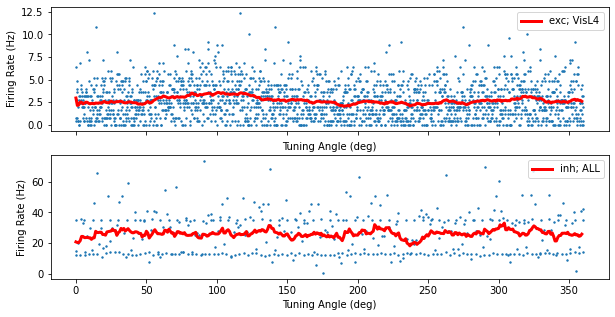

In [12]:
plot_tuning_angle_fr('output/spikes.h5')

Let us now see what happens if the weight_function takes into account the rules we described above and amplifies signals from similarly tuned neurons. Again, we don’t need to understand all the details of this function, aside from the fact that neurons are more strongly connected to other neurons with similar tuning. 

In [13]:
from bmtk.simulator import pointnet
from bmtk.simulator.pointnet.pyfunction_cache import synaptic_weight


@synaptic_weight
def DirectionRule_others(edge_props, source_nodes, target_nodes):
    src_tuning = source_nodes['tuning_angle'].values
    tar_tuning = target_nodes['tuning_angle'].values
    sigma = edge_props['weight_sigma'].values
    nsyn = edge_props['nsyns'].values
    syn_weight = edge_props['syn_weight'].values

    delta_tuning_180 = np.abs(np.abs(np.mod(np.abs(tar_tuning - src_tuning), 360.0) - 180.0) - 180.0)
    w_multiplier_180 = np.exp(-(delta_tuning_180 / sigma) ** 2)
       
    return np.array(syn_weight*w_multiplier_180*nsyn)


@synaptic_weight
def DirectionRule_EE(edge_props, source_nodes, target_nodes):
    src_tuning = source_nodes['tuning_angle'].values
    tar_tuning = target_nodes['tuning_angle'].values
    x_tar = target_nodes['x'].values
    x_src = source_nodes['x'].values
    z_tar = target_nodes['z'].values
    z_src = source_nodes['z'].values
    sigma = edge_props['weight_sigma'].values
    nsyn = edge_props['nsyns'].values
    syn_weight = edge_props['syn_weight'].values
    
    delta_tuning_180 = np.abs(np.abs(np.mod(np.abs(tar_tuning - src_tuning), 360.0) - 180.0) - 180.0)
    w_multiplier_180 = np.exp(-(delta_tuning_180 / sigma) ** 2)

    delta_x = (x_tar - x_src) * 0.07
    delta_z = (z_tar - z_src) * 0.04

    theta_pref = tar_tuning * (np.pi / 180.)
    xz = delta_x * np.cos(theta_pref) + delta_z * np.sin(theta_pref)
    sigma_phase = 1.0
    phase_scale_ratio = np.exp(-(xz**2 / (2*sigma_phase**2)))

    # To account for the 0.07 vs 0.04 dimensions. This ensures the horizontal neurons are scaled by 5.5/4
    # (from the midpoint of 4 & 7). Also, ensures the vertical is scaled by 5.5/7. This was a basic 
    # linear estimate to get the numbers (y = ax + b).
    theta_tar_scale = abs(abs(abs(180.0 - np.mod(np.abs(tar_tuning), 360.0)) - 90.0) - 90.0)
    phase_scale_ratio = phase_scale_ratio * (5.5 / 4.0 - 11.0 / 1680.0 * theta_tar_scale)

    return np.array(syn_weight*w_multiplier_180*phase_scale_ratio*nsyn)


configure = pointnet.Config.from_json('config.simulation_pointnet.recurrent.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

2022-07-24 07:30:39,176 [INFO] Created log file
2022-07-24 07:30:39,210 [INFO] Batch processing nodes for l4/0.
2022-07-24 07:30:39,371 [INFO] Batch processing nodes for lgn/0.
2022-07-24 07:30:39,380 [INFO] Batch processing nodes for bkg/0.
2022-07-24 07:30:39,497 [INFO] Setting up output directory
2022-07-24 07:30:39,498 [INFO] Building cells.
2022-07-24 07:30:39,600 [INFO] Building recurrent connections
2022-07-24 07:30:40,457 [INFO] Build virtual cell stimulations for lgn_spikes
2022-07-24 07:31:17,635 [INFO] Build virtual cell stimulations for bkg_spikes
2022-07-24 07:31:17,954 [INFO] Network created.
2022-07-24 07:31:17,981 [INFO] Starting Simulation
2022-07-24 07:31:25,338 [INFO] Simulation finished, finalizing results.
2022-07-24 07:31:25,575 [INFO] Done.


Now we can plot the firing rates as a function of the tuning_angle. As we can see on the plots below, the direction selectivity is preserved and even a bit enhanced here. Note that these adjustments to synaptic weights are in addition to the use of tuning_angle difference in calculating connection probability when building the network (see [6A. Building the Model](6A.%20Building%20the%20L4%20Network.ipynb)). In general, the presence and number of connections is a property of the network structure, while the connection weights are allowed to be adjusted dynamically. 

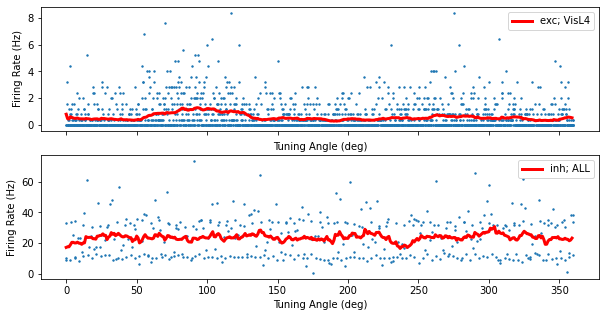

In [14]:
plot_tuning_angle_fr('output/spikes.h5')

/home/kael/apps/miniconda3/envs/bmtk-py38/lib/python3.8/site-packages/matplotlib-3.2.1-py3.8-linux-x86_64.egg/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


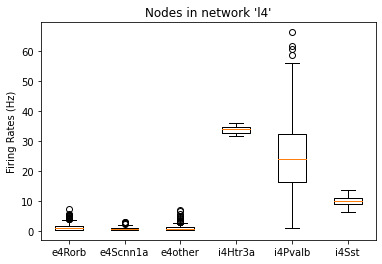

In [15]:
_ = plot_rates_boxplot(config_file='config.simulation_pointnet.recurrent.json', group_by='cell_line')

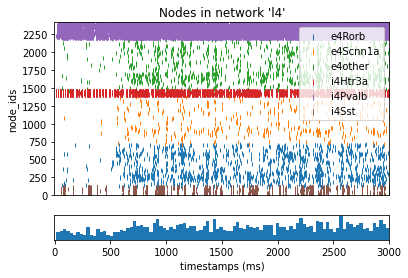

In [16]:
_ = plot_raster(config_file='config.simulation_pointnet.recurrent.json', group_by='cell_line')

### View the recurrent pointnet flash spike activity with VND

Launch VND by typing `vnd` on the Linux command line.

In the Visual Neuronal Dynamics window select, select menu item  **File : Open File with Edges**
and choose the file `Ch6_l4model/config.simulation_pointnet.recurrent.json'


In the Main tab, in the Represenations pane:

In the list of representations, after loading, the single, default selection is:

- Selected Neurons: stride 5
- Coloring Method: Type
- Style: soma

The "stride 5" (every 5th node) is the default view on loading for a  system this size.  TO see all the non-virtual nodes, for this representation, change **Selected Neurons**:

- Selected Neurons: all


Select menu item  **File : Add File with Spikes** and choose `Ch6_l4model/output/spikes.h5`
(A pre-prepared `spikes.h5` file for this simulation may also be provided.) 

In the Activity window, set

- Population:l4

Click **Update Selection**

set:
- Color: blue
- Sphere Scale: 10
- Sphere Resolution: 5
- Step: 1
- Time window: 2  _(or, try 4)_

If no sturctures are showing, you may need to select **Display : Reset View**.  (Or even, in the Main tab Representations pane,select the soma, "all" representation, then select **Display : Reset View**.)

Drag the time slider left and right, drag it back to the far left, then press the right-pointing play button to play through the series of spikes.  Change speed with the Speed slider.



Because the **weight_function** option provides a dynamic way to adjust the synaptic weights at simulation time without having to rebuild the network each time, which for large networks can take a significant amount of time, we can use this feature to fine tune the synaptic weight parameters using conjugate-gradient methods or grid searches - examples of which are shown in [this notebook](./6C.%20Parameter%20Tuning.ipynb).

#### Adding Perturbations

A common and useful technique in both in silico and in vivo neuroscience experiments is the application of perturbations to the network of interest and its components. BMTK provides a convenient interface for doing that. For example, if we want to completely suppress the i4Pvalb cells we can add a strong negative current clamp to the "inputs" section in the JSON config. The parameter "amp" sets the amplitude of the applied current in pA. You may need to use different values of "amp" depending on the cell models targeted by the perturbation and depending on the effect you desire to achieve.

```json
  "inputs": {
    "inh_current_clamp": {
        "input_type": "current_clamp",
        "module": "IClamp",
        "node_set": {"population": "l4", "cell_line": "i4Pvalb"},
        "amp": -2000.000,
        "delay": 1500.0,
        "duration": 1500.0
      }
```

2022-07-24 07:31:35,885 [INFO] Created log file
2022-07-24 07:31:35,913 [INFO] Batch processing nodes for l4/0.
2022-07-24 07:31:36,062 [INFO] Batch processing nodes for lgn/0.
2022-07-24 07:31:36,070 [INFO] Batch processing nodes for bkg/0.
2022-07-24 07:31:36,178 [INFO] Setting up output directory
2022-07-24 07:31:36,179 [INFO] Building cells.
2022-07-24 07:31:36,276 [INFO] Building recurrent connections
2022-07-24 07:31:37,095 [INFO] Build virtual cell stimulations for lgn_spikes
2022-07-24 07:32:16,557 [INFO] Build virtual cell stimulations for bkg_spikes
2022-07-24 07:32:18,924 [INFO] Network created.
2022-07-24 07:32:18,953 [INFO] Starting Simulation
2022-07-24 07:32:51,911 [INFO] Simulation finished, finalizing results.
2022-07-24 07:32:52,142 [INFO] Done.


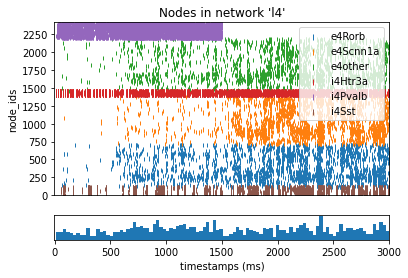

In [17]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.simulation_pointnet.pert_pvalb.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

_ = plot_raster(config_file='config.simulation_pointnet.pert_pvalb.json', group_by='cell_line')

### View the i4Pvalb-suppression perturbed pointnet spike activity with VND

View the spike activity as earlier in the chapter, now with model file `config.simulation_pointnet.pert_pvalb.json` and the latest `spikes.h5` file that your simulation has produced. (A pre-prepared `spikes.h5` file for this simulation may also be provided.) 

Visualize spike activity similarly for the below suggested simulated simulations.
To simultaneously examine activity from different simulations, launch mulitple VND instances.

Not only are we able to completely knock out the Parvalbumin cells in Layer 4, we can see and compare the effect this has on the rest of the recurrently-connected network. Similarly we can excite the cells with a strong positive current, or even excite/inhibit different cells at different times during the same simulation.

BMTK offers much flexibility in how one defines the population of nodes to which the perturbation is applied. In the example below, we just changed the *node_set* so that it targets only the excitatory "e4Rorb" and "e4Scnn1a" cells, and changed the *amp*litude to a large positive value:

```json
  "inputs": {
    "exc_current_clamp": {
        "input_type": "current_clamp",
        "module": "IClamp",
        "node_set": {
          "population": "l4",
          "cell_line": ["e4Rorb", "e4Scnn1a"],
        },
        "amp": 2000.000,
        "delay": 1500.0,
        "duration": 1500.0
      }
```

2022-07-24 07:32:54,822 [INFO] Created log file
2022-07-24 07:32:54,861 [INFO] Batch processing nodes for l4/0.
2022-07-24 07:32:54,997 [INFO] Batch processing nodes for lgn/0.
2022-07-24 07:32:55,005 [INFO] Batch processing nodes for bkg/0.
2022-07-24 07:32:55,116 [INFO] Setting up output directory
2022-07-24 07:32:55,117 [INFO] Building cells.
2022-07-24 07:32:55,274 [INFO] Building recurrent connections
2022-07-24 07:32:56,096 [INFO] Build virtual cell stimulations for lgn_spikes
2022-07-24 07:33:34,009 [INFO] Build virtual cell stimulations for bkg_spikes
2022-07-24 07:33:36,698 [INFO] Network created.
2022-07-24 07:33:36,726 [INFO] Starting Simulation
2022-07-24 07:34:17,888 [INFO] Simulation finished, finalizing results.
2022-07-24 07:34:20,289 [INFO] Done.


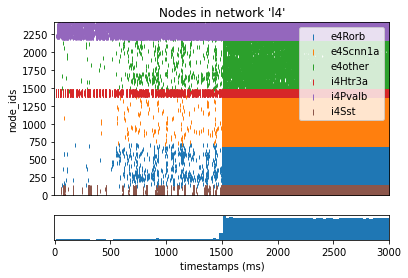

In [18]:
configure = pointnet.Config.from_json('config.simulation_pointnet.pert_exc.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

_ = plot_raster(config_file='config.simulation_pointnet.pert_exc.json', group_by='cell_line')

We can also run multiple perturbations in the same simulation, in series or in parallel. We just need to add multiple sections in the "inputs":

```json
  "inputs": {
    "current_clamp_1": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": {
        "population": "l4",
        "cell_line": "e4Rorb"
      },
      "amp": -2000.000,
      "delay": 500.0,
      "duration": 500.0
    },
    "current_clamp_2": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": {
        "population": "l4",
        "cell_line": "e4Rorb"
      },
      "amp": 2000.000,
      "delay": 1500.0,
      "duration": 500.0
    },
    "current_clamp_3": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": {
        "population": "l4",
        "ei": "i"
      },
      "amp": -2000.000,
      "delay": 2500.0,
      "duration": 500.0
    }
  },
```

2022-07-24 07:35:00,952 [INFO] Created log file
2022-07-24 07:35:00,987 [INFO] Batch processing nodes for l4/0.
2022-07-24 07:35:01,227 [INFO] Batch processing nodes for lgn/0.
2022-07-24 07:35:01,237 [INFO] Batch processing nodes for bkg/0.
2022-07-24 07:35:01,356 [INFO] Setting up output directory
2022-07-24 07:35:01,357 [INFO] Building cells.
2022-07-24 07:35:01,474 [INFO] Building recurrent connections
2022-07-24 07:35:02,481 [INFO] Build virtual cell stimulations for lgn_spikes
2022-07-24 07:35:42,266 [INFO] Build virtual cell stimulations for bkg_spikes
2022-07-24 07:35:48,708 [INFO] Network created.
2022-07-24 07:35:48,736 [INFO] Starting Simulation
2022-07-24 07:36:26,634 [INFO] Simulation finished, finalizing results.
2022-07-24 07:36:27,361 [INFO] Done.


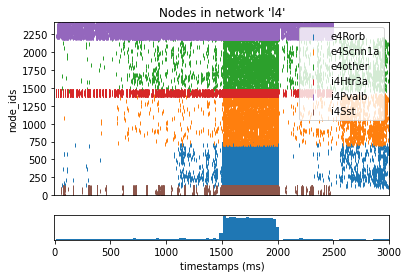

In [19]:
configure = pointnet.Config.from_json('config.simulation_pointnet.pert_multiple.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

_ = plot_raster(config_file='config.simulation_pointnet.pert_multiple.json', group_by='cell_line')

In the above examples we selected a subset of nodes based on their properties. We also have the option to perturb individual or select set of nodes based on their assigned *node_id*s. Here we just have to tell the config the population of nodes to use (since for some models there might be multiple populations in a single simulation) and pass a list of node_ids:

```json
  "inputs": {
    "current_clamp_1": {
        "input_type": "current_clamp",
        "module": "IClamp",
        "node_set": {
          "population": "l4",
          "node_id": [250, 500, 750, 1250, 1500, 1750]
        },
        "amp": 2000.000,
        "delay": 500.0,
        "duration": 2500.0
      }
  },

```

2022-07-24 07:36:39,126 [INFO] Created log file
2022-07-24 07:36:39,178 [INFO] Batch processing nodes for l4/0.
2022-07-24 07:36:39,317 [INFO] Batch processing nodes for lgn/0.
2022-07-24 07:36:39,324 [INFO] Batch processing nodes for bkg/0.
2022-07-24 07:36:39,435 [INFO] Setting up output directory
2022-07-24 07:36:39,436 [INFO] Building cells.
2022-07-24 07:36:39,544 [INFO] Building recurrent connections
2022-07-24 07:36:40,407 [INFO] Build virtual cell stimulations for lgn_spikes
2022-07-24 07:37:18,394 [INFO] Build virtual cell stimulations for bkg_spikes
2022-07-24 07:37:20,592 [INFO] Network created.
2022-07-24 07:37:20,622 [INFO] Starting Simulation
2022-07-24 07:37:56,068 [INFO] Simulation finished, finalizing results.
2022-07-24 07:37:56,309 [INFO] Done.


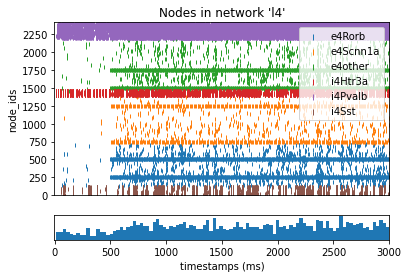

In [20]:
configure = pointnet.Config.from_json('config.simulation_pointnet.pert_individual.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

_ = plot_raster(config_file='config.simulation_pointnet.pert_individual.json', group_by='cell_line')

### View the individual-nodes perturbation pointnet activity with VND

View the spike activity as earlier in the chapter, now with model file `config.simulation_pointnet.pert_individual.json` and the latest `spikes.h5` file that your simulation has produced. (A pre-prepared `spikes.h5` file for this simulation may also be provided.)


Direct link to <a href= "http://www.ks.uiuc.edu/~barryi/bmtk_allen_workshop_2022/ch6_indiv_pert_spikes-rotations.mp4">  spike activity movie with rotation </a> and a <a href="http://www.ks.uiuc.edu/~barryi/bmtk_allen_workshop_2022/ch6_indiv_pert_spikes_static_10x.mp4"> non-rotating spike activity movie</a>, both from the individual-nodes perturbation pointnet simulation.
